In [1]:
import os
import time
import psycopg2
from psycopg2 import Error
import re
import pandas as pd
import requests
from psycopg2 import sql
from convertdate import persian
import plotly.graph_objects as go
from persiantools.jdatetime import JalaliDate
import plotly.graph_objects as go
import pandas as pd
from IPython.display import display, HTML

In [2]:
def clean_value(value):
    if value == '-' or not value:
        return value

    match = re.search(r'<span class="(?:low|high)" dir="ltr">([\d%,]+)<', value)

    if match:
        number = match.group(1).replace(',', '')  # Remove commas

        if 'class="high"' in value:
            return number
        elif 'class="low"' in value:
            return f'-{number}'

    return value.strip()


In [3]:
def fetch_and_process_data(url):
    response = requests.get(url)
    data_json = response.json()

    # Extract data from JSON
    data = data_json.get('data', [])

    # Process the data
    processed_data = []
    for row in data:
        row_data = [clean_value(item) for item in row]
        processed_data.append(row_data)

    # Create DataFrame with column names
    df = pd.DataFrame(processed_data,
                      columns=['opening', 'lowest', 'highest', 'closing', 'change_amount', 'change_percentage',
                               'gregorian_date',
                               'persian_date'])

    # Select relevant columns
    df_filtered = df[['closing', 'persian_date', 'gregorian_date']]

    # Convert 'closing' to numeric
    df_filtered.loc[:, 'closing'] = df_filtered['closing'].replace({',': ''}, regex=True).astype(float)

    return df_filtered

In [4]:
def convert_persian_to_jalali(persian_date):
    year, month, day = map(int, persian_date.split('/'))  # Split and convert to integers
    return JalaliDate(year, month, day)

In [5]:
# URLs for different types of data
urls = {
    'Gold': 'https://api.tgju.org/v1/market/indicator/summary-table-data/geram18?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Dollar': 'https://api.tgju.org/v1/market/indicator/summary-table-data/price_dollar_rl?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/sekee?lang=fa&order_dir=asc&convert_to_ad=1&_='
}

all_df = []

# Fetch and process the data
for market_name, url in urls.items():
    fetched_data_df = fetch_and_process_data(url)

    fetched_data_df['year_month'] = fetched_data_df['persian_date'].str[:7]  # Take 'YYYY/MM' from 'YYYY/MM/DD'

    fetched_data_df['market_type'] = market_name

    all_df.append(fetched_data_df)

df = pd.concat(all_df, ignore_index=True)

df['persian_date_jalali'] = df['persian_date'].apply(convert_persian_to_jalali)

df = df[df['persian_date_jalali'] > JalaliDate(1395, 1, 1)]

# Group by market type and year_month
market_names = {'Coin': 'سکه', 'Gold': 'طلا', 'Dollar': 'دلار'}
monthly_data_dict = {}

for market_type in df['market_type'].unique():
    market_data = df[df['market_type'] == market_type]

    # Calculate monthly average price and percentage change
    grouped = market_data.groupby('year_month').agg(
        avg_closing_price=('closing', 'mean')
    )
    grouped['price_change'] = (grouped['avg_closing_price'] / grouped['avg_closing_price'].iloc[0] - 1) * 100

    # Add data to dictionary
    monthly_data_dict[market_names.get(str(market_type), 'Unknown')] = {
        'year_month': grouped.index.tolist(),
        'price_change': grouped['price_change'].tolist()
    }

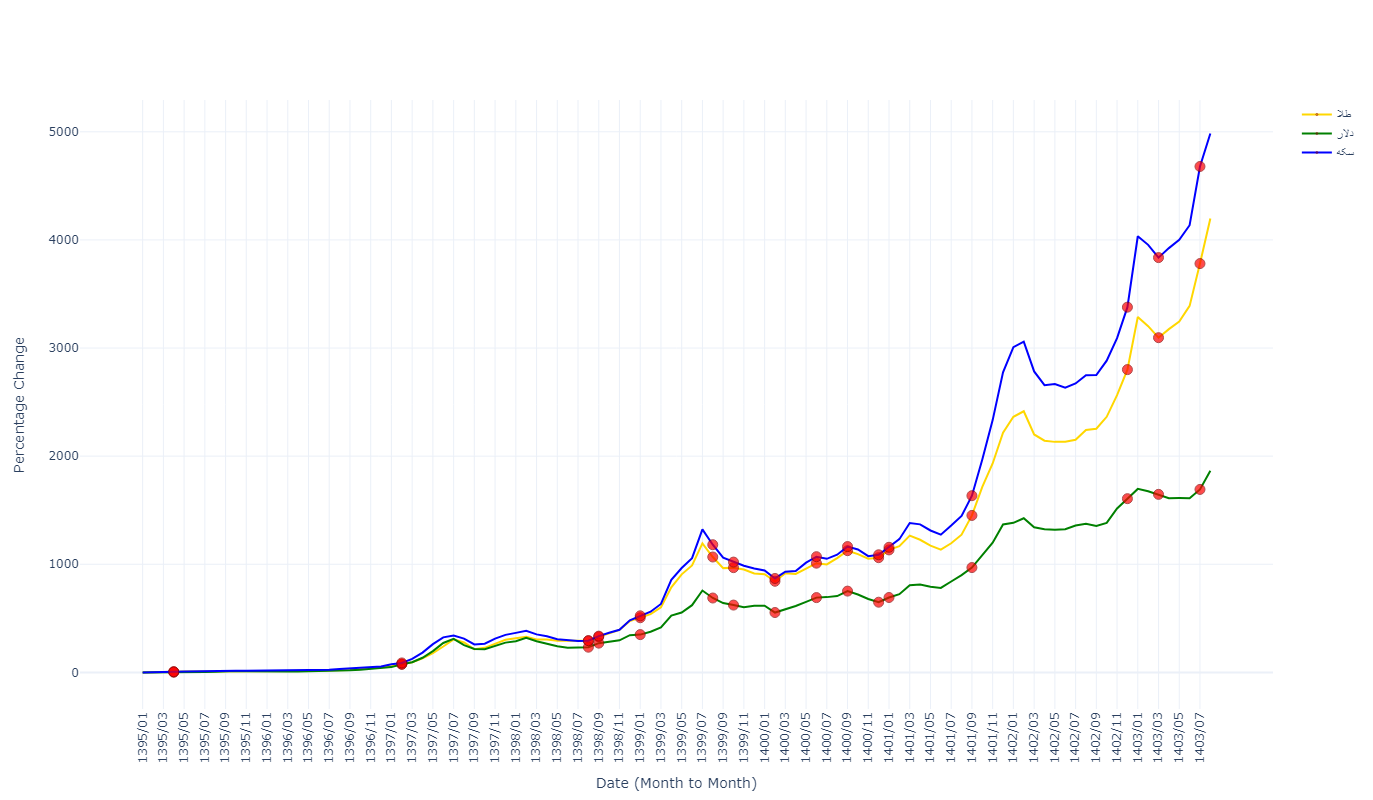

In [7]:
# Custom height for the output cell
display(HTML('<style>.output { height: 800px; overflow-y: scroll; }</style>'))

# Load events data from CSV
events_df = pd.read_csv("events.csv")

colors = {
    "طلا": "gold",
    "دلار": "green",
    "سکه": "blue"
}

# Create a figure
fig = go.Figure()

# Iterate over the monthly data dictionary to add traces for each market
for name, monthly_data in monthly_data_dict.items():
    hover_texts = []
    marker_colors = []
    marker_sizes = []

    for date in monthly_data['year_month']:
        # Check if an event matches this date
        matching_event = events_df[events_df['تاریخ شمسی'] == date]
        if not matching_event.empty:
            # Build the hover text for the matching event
            event_name = matching_event.iloc[0]['رویداد']
            event_impact = matching_event.iloc[0]['تأثیر بر بازارها']
            hover_texts.append(f"<b>{event_name}</b><br>Impact: {event_impact}")
            marker_colors.append('red')  # Highlight event points in red
            marker_sizes.append(10)  # Highlight event points with larger size
        else:
            hover_texts.append("")  # No event for this date
            marker_colors.append('rgba(0,0,0,0)')  # Transparent color for non-event points
            marker_sizes.append(0)  # Invisible marker size

    # Add trace for each market
    fig.add_trace(go.Scatter(
        x=monthly_data['year_month'],
        y=monthly_data['price_change'],
        mode='lines+markers',
        name=name,
        hoverinfo="text",  # Only show custom hover text
        text=hover_texts,  # Custom hover text
        marker=dict(
            color=marker_colors,  # Assign colors based on event occurrence
            size=marker_sizes,  # Show marker size only for events
            line=dict(width=1, color="darkred")  # Optional: outline markers
        ),
        line=dict(color=colors.get(name, "black"), width=2)  # Default to black if not in colors
    ))

# Chart settings
fig.update_layout(
    xaxis_title="Date (Month to Month)",
    yaxis_title="Percentage Change",
    xaxis=dict(
        type="category",
        tickangle=-90
    ),
    template='plotly_white',
    showlegend=True,
    height=800  # Set the height of the entire chart
)

# Display the figure
fig.show()
